# Polynomial Linear Regression

Haytham Mohamed - INFS 890 - Spring 2020

In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
import seaborn as sns
from sklearn import preprocessing, metrics, feature_selection
from datetime import datetime
from scipy import stats
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

sns.set()
sns.set(color_codes=True)
#sns.set_color_codes()

pd.options.display.max_rows = 15
pd.options.display.float_format = '{:,.3f}'.format

In [186]:
# 1- read data file
# 1- read processed file
file_dir = '../data/processed-data/'

#data_file = 'missing_outliers_processed_dataset.csv'
data_file = 'normalized_dataset.csv'
#data_file = 'factored_dataset.csv'
#data_file = 'no_missing_outliers_dataset.csv'

data = pd.read_csv(file_dir + data_file)

In [187]:
data.head(5)

,ltcy,svc_cpu_use,svc_cpu_thr,svc_net_use,svc_disk_use,system_cpu_use,system_cpu_sat,system_net_use,svc_req_size,svc_resp_size,svc_pods,svc_req_rate
0,0.332,0.557,0.332,0.325,0.037,16.982,1.591,3.206,0.002,0.012,7.000,0.980
1,0.400,0.616,0.300,0.351,0.047,20.583,1.608,3.552,0.003,0.019,7.000,1.620
2,0.469,0.608,0.316,0.362,0.039,19.448,1.390,3.586,0.003,0.024,7.000,2.180
3,0.490,0.624,0.300,0.362,0.108,17.319,1.730,3.512,0.003,0.022,6.000,2.130
4,0.500,0.608,0.316,0.374,0.133,16.650,1.917,3.449,0.003,0.023,3.000,2.220


## Polynomial Linear Regression Model

In [188]:
targets = data['ltcy']
inputs = data.drop(['ltcy'], axis=1)

#inputs_scaled = scaler.fit_transform(inputs)
#x_train, x_test, y_train, y_test = train_test_split(inputs_scaled, targets, test_size=0.2, random_state=365)

x_train, x_test, y_train, y_test = \
    train_test_split(inputs, targets, test_size=0.2, random_state=365)

# for better convergence and result scale target to values between 0 - 1
y_train_max = y_train.max()
y_test_max = y_test.max()

y_train = y_train / y_train_max
y_test = y_test / y_test_max


In [189]:
# standardize the features
scaler = StandardScaler()

# using SelectFromModel metatransformer to select features
#clf = LassoCV()
#sfm = SelectFromModel(clf, threshold=0.01)

clf = RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=15)
sfm = SelectFromModel(clf,threshold='0.8*mean')

# regression model
reg = LinearRegression(fit_intercept=False)
poly = PolynomialFeatures(degree=5)

pipe = Pipeline([
    ('scaler', scaler),
    ('selector', sfm),
    ('poly', poly),
    ('regression', reg)
])

kfold = KFold(n_splits=10, shuffle=False)

param_grid = {
    'selector__threshold': [.1, .05, .02, .01, .005, 0.001]
}

search = GridSearchCV(pipe, param_grid,scoring='neg_mean_squared_error'
                      , return_train_score= True, cv=kfold, verbose=0, n_jobs=-1)

search.fit(x_train, y_train)

print ("Done..!")

Done..!


In [190]:
y_hat = search.predict(x_train)

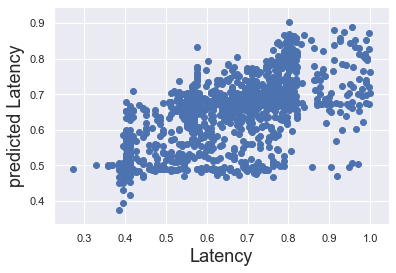

In [191]:
plt.scatter(y_train, y_hat)
plt.xlabel('Latency', size=18)
plt.ylabel("predicted Latency", size=18)
#plt.xlim(-2,3)
#plt.ylim(-3,1)
plt.show()

Text(0.5, 1.0, 'Residual PDF')

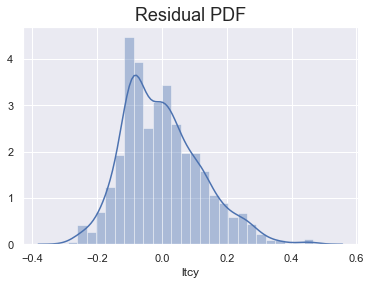

In [192]:
sns.distplot(y_train - y_hat)
plt.title('Residual PDF', size=18)

In [193]:
# R-Squared
search.score(x_train, y_train)

-0.01436903093792262

### Testing

In [194]:
y_hat_test = search.predict(x_test)

<function matplotlib.pyplot.show(*args, **kw)>

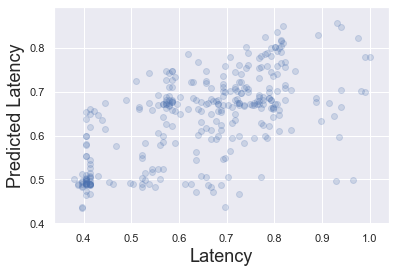

In [195]:
plt.scatter(y_test, y_hat_test, alpha=0.2)
plt.xlabel('Latency', size=18)
plt.ylabel('Predicted Latency', size=18)
plt.show

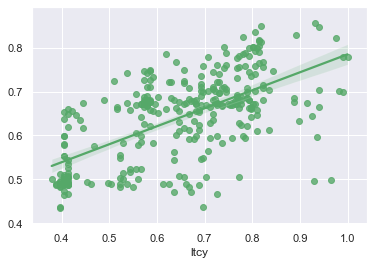

In [210]:
ax = sns.regplot(x=y_test, y=y_hat_test, color='g')

In [196]:
perf = pd.DataFrame(np.exp(y_hat_test), columns=['prediction'])
y_test = y_test.reset_index(drop=True)
perf['target'] = np.exp(y_test)
perf.head()

,prediction,target
0,1.967,1.774
1,1.995,1.785
2,1.655,1.688
3,2.130,2.278
4,1.989,1.827


In [197]:
# testing mean_absolute_percentage_error
perf['residual'] = perf['prediction'] - perf['target']
perf['difference%'] = np.absolute(perf['residual'] * 100 / perf['target'])
perf

,prediction,target,residual,difference%
0,1.967,1.774,0.192,10.849
1,1.995,1.785,0.211,11.798
2,1.655,1.688,-0.033,1.964
3,2.130,2.278,-0.148,6.498
4,1.989,1.827,0.162,8.862
...,...,...,...,...
312,2.180,2.718,-0.539,19.818
313,1.971,2.145,-0.173,8.084
314,2.155,2.278,-0.123,5.411
315,1.930,2.250,-0.320,14.216


In [198]:
perf.describe()

,prediction,target,residual,difference%
count,317.000,317.000,317.000,317.000
mean,1.905,1.929,-0.024,9.324
std,0.188,0.295,0.232,6.943
min,1.543,1.461,-0.980,0.024
25%,1.737,1.710,-0.160,3.770
50%,1.946,1.949,-0.003,8.556
75%,2.019,2.154,0.140,12.833
max,2.356,2.718,0.422,37.327


In [199]:
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.2f' % x)
perf.sort_values(by = ['difference%'])

,prediction,target,residual,difference%
146,2.23,2.23,-0.00,0.02
105,1.98,1.98,-0.00,0.06
316,2.23,2.23,-0.00,0.14
291,2.26,2.26,0.00,0.15
276,1.97,1.97,0.00,0.15
162,1.99,2.00,-0.00,0.21
106,2.27,2.26,0.01,0.28
201,2.01,2.01,0.01,0.30
130,2.20,2.19,0.01,0.40
282,2.06,2.07,-0.01,0.46


# Prediction Accuracy

In [200]:
r2_test = metrics.r2_score(y_test, y_hat_test)
print('R2 (testing) = {}'.format(r2_test))

# also: R-Squared could obtain with
# pline.score(x_test, y_test)

R2 (testing) = 0.3996940772606331


In [201]:
print(np.sqrt(mean_squared_error(y_test,y_hat_test)))

0.11921716932183588
